In [22]:
using MLDataPattern
using ProgressMeter
using Polyhedra
using CDDLib
import PyPlot
PyPlot.pygui(true)
using Plots
pyplot()

Plots.PyPlotBackend()

In [4]:
using PyCall
@pyimport scipy.spatial as spatial

In [5]:
include("pympc.jl")

INFO: Precompiling module Gurobi.


Test Summary:    | Pass  Total
test sensitivity |  267    267


PyMPC

In [171]:
mass = 1.
l = 1.
g = 10.
N = 4
# A = [0. 1.;
#      g/l 0.]
# B = [0 1/(mass*l^2.)]'
A = [0. 1; 0 0]
B = [0. 1]'
Δt = .1
pysys = PyMPC.dynamical_systems.DTLinearSystem[:from_continuous](A, B, Δt)

# x_max = [pi/6, pi/20/(N*Δt)]
x_max = [1., 1]
x_min = -x_max
# u_max = [mass*g*l*pi/8.]
u_max = [1.]
u_min = -u_max
times = 0:Δt:N*Δt

Q = 10 * eye(2)
R = eye(1)

X_bounds = PyMPC.geometry.Polytope[:from_bounds](reshape(x_min, 2, 1), reshape(x_max, 2, 1))[:assemble]()
U_bounds = PyMPC.geometry.Polytope[:from_bounds](reshape(u_min, 1, 1), reshape(u_max, 1, 1))[:assemble]()
controller = PyMPC.control.MPCController(pysys, N, "two", Q, R, X=X_bounds, U=U_bounds)

qp = controller[:condensed_program]

data = Vector{Tuple{Vector{Float64}, Matrix{Float64}}}()

while length(data) < 30
    x = x_min + rand(length(x_min)) .* (x_max - x_min)
    status, u, J = PyMPC.solve_qp(qp, x)
    if status == :Optimal
        push!(data, (x, hcat(u[1:1, :], J[1:1, :])))
    end
end

train_data, test_data = splitobs(data, 0.5);

In [172]:
include("nets.jl")

Test Summary: | Pass  

Total
feedforward   |  200    200
Test Summary: | Pass  Total
random shapes |  392    392
Test Summary:     | Pass  Total
compiled jacobian | 1000   1000


Nets

In [177]:
widths = [2, 4, 8, 4, 1]
# shapes = [(4, 2), (4, 4), (4, 4), (1, 4)]
net = Nets.Net(widths)

sgdopts = Nets.SGDOpts(
    learning_rate=0.1,
    batch_size=3,
    learning_decay=0.95)
nepoch = 40

predict = (params, x) -> Nets.predict_sensitivity(net, params, x)
loss = (params, x, y) -> sum(abs2, y - predict(params, x))
loss_no_sensitivity = (params, x, y) -> sum(abs2, y[:, 1] - predict(params, x)[:, 1])

(::#971) (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00



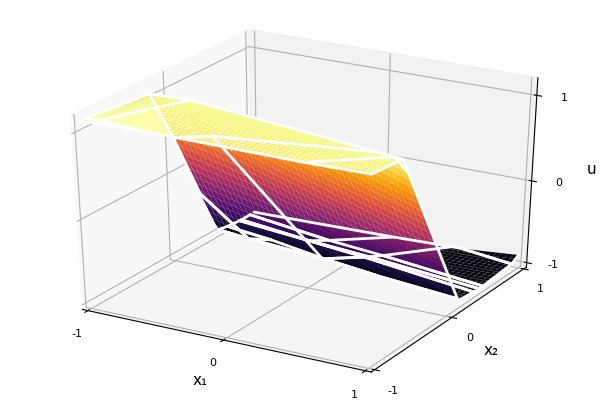

In [178]:
params = 2 * (rand(net) .- 0.5)
losses = Float64[]

@showprogress for i in 1:nepoch
    Nets.sgd!(loss, params, train_data, sgdopts)
    push!(losses, mean(xy -> loss_no_sensitivity(params, xy[1], xy[2]), test_data))
end


xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt = surface(xx, yy, (x, y) -> predict(params, [x, y])[1], 
legend=nothing,
xlabel="x₁",
ylabel="x₂",
zlabel="u"
)

bounds = hrep(polyhedron(SimpleVRepresentation([x_min[1] x_min[2]; x_min[1] x_max[2]; x_max[1] x_max[2]; x_max[1] x_min[2]]), CDDLibrary()))
results = Nets.explore(Nets.Params(net, params), bounds, [0.0, 0])
for (i, (state, p)) in enumerate(results)
    V = SimpleVRepresentation(vrep(polyhedron(p, CDDLibrary()))).V
    if !isempty(V)
        hull = spatial.ConvexHull(V)
        points = [hull[:points][i + 1, :] for i in hull[:vertices]]
        x = [p[1] for p in points]
        y = [p[2] for p in points]
        plot!(plt, x, y, [Nets.predict(net, params, [x[i], y[i]])[1] for i in eachindex(x)], linecolor=:white, linewidth=2)
    end
end

plt

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00



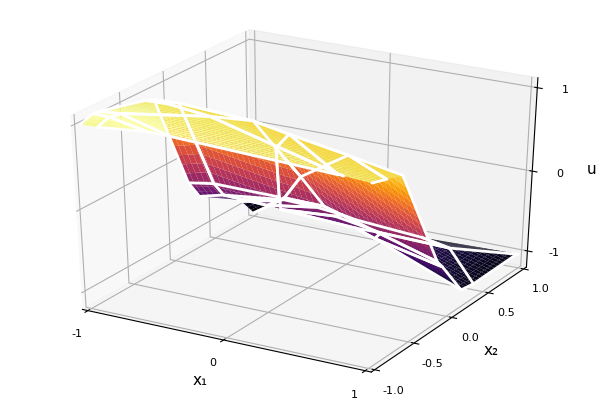

In [179]:
losses_ns = Float64[]
params = 2 * (rand(net) .- 0.5)

@showprogress for i in 1:nepoch
    Nets.sgd!(loss_no_sensitivity, params, train_data, sgdopts)
    push!(losses_ns, mean(xy -> loss_no_sensitivity(params, xy[1], xy[2]), test_data))
end


xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt = surface(xx, yy, (x, y) -> predict(params, [x, y])[1], 
legend=nothing,
xlabel="x₁",
ylabel="x₂",
zlabel="u"
)

bounds = hrep(polyhedron(SimpleVRepresentation([x_min[1] x_min[2]; x_min[1] x_max[2]; x_max[1] x_max[2]; x_max[1] x_min[2]]), CDDLibrary()))
results = Nets.explore(Nets.Params(net, params), bounds, [0.0, 0])
for (i, (state, p)) in enumerate(results)
    V = SimpleVRepresentation(vrep(polyhedron(p, CDDLibrary()))).V
    if !isempty(V)
        hull = spatial.ConvexHull(V)
        points = [hull[:points][i + 1, :] for i in hull[:vertices]]
        x = [p[1] for p in points]
        y = [p[2] for p in points]
        plot!(plt, x, y, [Nets.predict(net, params, [x[i], y[i]])[1] for i in eachindex(x)], linecolor=:white, linewidth=2)
    end
end

plt


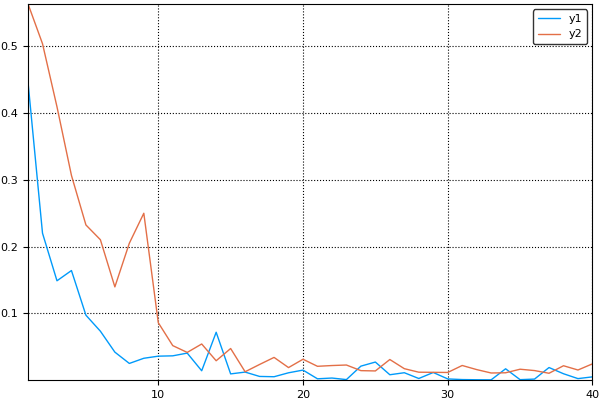

In [180]:
plt = plot(losses)
plot!(plt, losses_ns)
plt


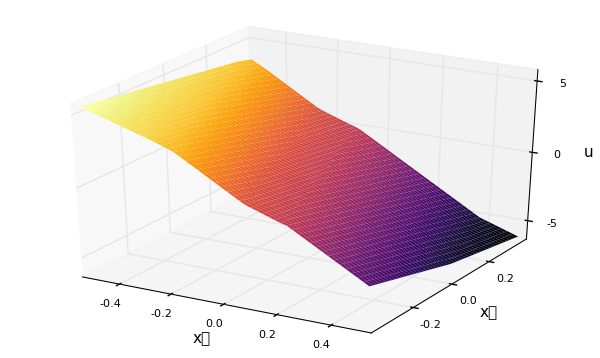

In [72]:
mx_params = vec(readdlm("weights.csv"))
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt = surface(xx, yy, (x, y) -> predict(mx_params, [x, y])[1], 
legend=nothing,
xlabel="x₁",
ylabel="x₂",
zlabel="u"
)
plt

In [66]:
gui()